# YellowCab

# Experiment Tracking and Model Management with MLFlow

There are many ways to use the MLFlow Tracking API. For simple local uses, the best is to leave the data management to MLFlow and let it store runs, metrics, models and artifacts locally. For more advanced usage, all of this information can be stored in databases. You can find the detailed on MLFlow's documentation [here](https://mlflow.org/docs/latest/tracking.html#scenario-1-mlflow-on-localhost).

## Exploring MLFlow

MLflow setup:
* Tracking server: no
* Backend store: local filesystem
* Artifacts store: local filesystem

The experiments can be explored locally by launching the MLflow UI.

First make sure you run the mlflow server in this challenge directory. Open a new terminal and run the following command:

```bash
mlflow ui
```
Let's print the tracking server URI, where the experiments and runs are going to be logged. We observe it refers to a local path. 

In [5]:
import mlflow


mlflow.set_tracking_uri("http://localhost:5000")
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")


tracking URI: 'http://localhost:5000'


After this initialization, we can connect create a client to connect to the API and see what experiments are present.

By refering to mlflow's [documentation](https://mlflow.org/docs/latest/python_api/mlflow.client.html), create a client and display a list of the available experiments using the search_experiments function. This function could prove useful later to programatically explore experiments (rather than in the UI)

In [6]:
from mlflow import MlflowClient

client = MlflowClient()
client.search_experiments()

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1741949206911, experiment_id='0', last_update_time=1741949206911, lifecycle_stage='active', name='Default', tags={}>]

We see that there is a default experiment for which the runs are stored locally in the mlruns folder.

### Creating an experiment and logging a new run

An experiment is a logical entity regrouping the logs of multiple attempts at solving a same problem, called runs. \
We will now work with the classic sklearn dataset iris. Our goal here is to manage to classify the different iris species. To track our models performance, we will log every attempt as a "run" and create a new experiment "iris-experiment-1" to regroup them.

Lookup the mlflow.run and mlflow.start_run functions [here](https://mlflow.org/docs/latest/python_api/mlflow.html?highlight=start_run#mlflow.start_run) to find out how to manage runs.
Explore [this part](https://mlflow.org/docs/latest/python_api/mlflow.html) to learn more about the log_params, log_metrics and log_artifact functions. Find out how to log sklearn models [here](https://mlflow.org/docs/latest/python_api/mlflow.sklearn.html])

Complete the following in order to log the parameters, interesting metrics and the model.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, f1_score

mlflow.set_experiment("iris-experiment-1")
X, y = load_iris(return_X_y=True)

params = {"C": 0.1, "random_state": 42}

model = LogisticRegression(**params).fit(X, y)
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average="weighted")

with mlflow.start_run() as run:
    run_id = run.info.run_id
    print(f"run ID: '{run_id}'")
    # Log Params
    mlflow.log_params(params)
    
    # Log Metrics)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1', f1)

    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")
    
    # Log Model with signature, 
    from mlflow.models.signature import infer_signature
    signature = infer_signature(X, model.predict(X))
    mlflow.sklearn.log_model(model, "model"
                             , registered_model_name="iris_lr_model"
                             , signature=signature)
    

    # Log Tags
    mlflow.set_tag("mlflow.source.type", "notebook")
    

2025/03/14 10:47:26 INFO mlflow.tracking.fluent: Experiment with name 'iris-experiment-1' does not exist. Creating a new experiment.


run ID: 'cceeaf52e24c4ca28b6fb8460284cd44'
default artifacts URI: 'mlflow-artifacts:/592261138735497612/cceeaf52e24c4ca28b6fb8460284cd44/artifacts'


Successfully registered model 'iris_lr_model'.
2025/03/14 10:47:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_lr_model, version 1


🏃 View run polite-swan-338 at: http://localhost:5000/#/experiments/592261138735497612/runs/cceeaf52e24c4ca28b6fb8460284cd44
🧪 View experiment at: http://localhost:5000/#/experiments/592261138735497612


Created version '1' of model 'iris_lr_model'.


In [8]:
experiments = client.search_experiments()
experiments

[<Experiment: artifact_location='mlflow-artifacts:/592261138735497612', creation_time=1741949246038, experiment_id='592261138735497612', last_update_time=1741949246038, lifecycle_stage='active', name='iris-experiment-1', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1741949206911, experiment_id='0', last_update_time=1741949206911, lifecycle_stage='active', name='Default', tags={}>]

Try running the training script with various parameters to have runs to compare.
You can now explore your run(s) using the ui: \
(Paste "mlflow ui --host 0.0.0.0 --port 5002" in your terminal, or run the cell below)

**N.B.** Make sure you are in the lecture folder and not the repo root!

In [9]:
#!mlflow ui --host 0.0.0.0 --port 5002

You will have to kill the cell to continue experimenting

### Interacting with the model registry

If you are satisfied with the last run's model, you can transform the logged model into a registered model. It will be logged in the Model Registry, which makes it easier to use in production and manage versions.

In [10]:
# We already have our run id from above. Let's use it to register the model

result = mlflow.register_model(f"runs:/{run_id}/models", "iris_lr_model")

Registered model 'iris_lr_model' already exists. Creating a new version of this model...
2025/03/14 10:47:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_lr_model, version 2
Created version '2' of model 'iris_lr_model'.


In [11]:
# Use Case

Now we will get back to our taxi rides use case: 

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import root_mean_squared_error

from typing import List
from scipy.sparse import csr_matrix
import mlflow

## 0 - Download Data

In [13]:
!pip install gdown --quiet

In [14]:
import gdown
import os

DATA_FOLDER = "../../data"
train_path = f"{DATA_FOLDER}/yellow_tripdata_2021-01.parquet"
test_path = f"{DATA_FOLDER}/yellow_tripdata_2021-02.parquet"
predict_path = f"{DATA_FOLDER}/yellow_tripdata_2021-03.parquet"


if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)
    print(f"New directory {DATA_FOLDER} created!")

    gdown.download(
        "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet",
        train_path,
        quiet=False,
    )
    gdown.download(
        "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet",
        test_path,
        quiet=False,
    )
    gdown.download(
        "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-03.parquet",
        predict_path,
        quiet=False,
    )

Downloading...
From: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet
To: /home/florian.pasquier2000/code/data/yellow_tripdata_2021-01.parquet


New directory ../../data created!


100%|██████████| 21.7M/21.7M [00:00<00:00, 162MB/s]
Downloading...
From: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet
To: /home/florian.pasquier2000/code/data/yellow_tripdata_2021-02.parquet
100%|██████████| 21.8M/21.8M [00:00<00:00, 155MB/s]
Downloading...
From: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-03.parquet
To: /home/florian.pasquier2000/code/data/yellow_tripdata_2021-03.parquet
100%|██████████| 30.0M/30.0M [00:00<00:00, 378MB/s]


## 1 - Load data

In [15]:
def load_data(path: str):
    return pd.read_parquet(path)


train_df = load_data(train_path)
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


## 2 - Prepare the data

Let's prepare the data to make it Machine Learning ready. \
For this, we need to clean it, compute the target (what we want to predict), and compute some features to help the model understand the data better.

### 2-1 Compute the target

We want to predict a taxi trip duration in minutes. Let's compute it as a difference between the drop-off time and the pick-up time for each trip.

In [16]:
def compute_target(
    df: pd.DataFrame,
    pickup_column: str = "tpep_pickup_datetime",
    dropoff_column: str = "tpep_dropoff_datetime",
) -> pd.DataFrame:
    df["duration"] = df[dropoff_column] - df[pickup_column]
    df["duration"] = df["duration"].dt.total_seconds() / 60
    return df


train_df = compute_target(train_df)

count    1.369769e+06
mean     1.391168e+01
std      1.312006e+02
min     -1.350846e+05
25%      5.566667e+00
50%      9.066667e+00
75%      1.461667e+01
max      2.881770e+04
Name: duration, dtype: float64

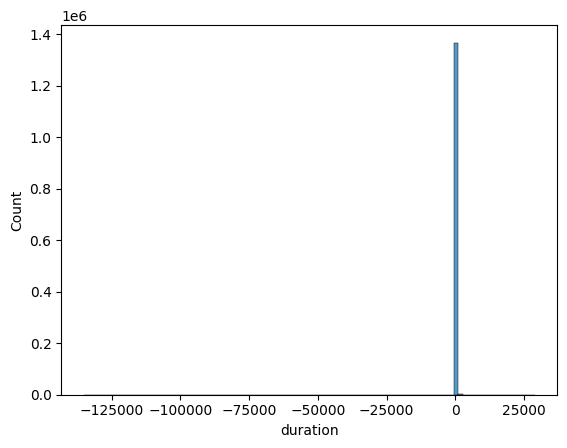

In [17]:
sns.histplot(train_df["duration"], bins=100)
train_df["duration"].describe()


Let's remove outliers and reduce the scope to trips between 1 minute and 1 hour

<Axes: xlabel='duration', ylabel='Count'>

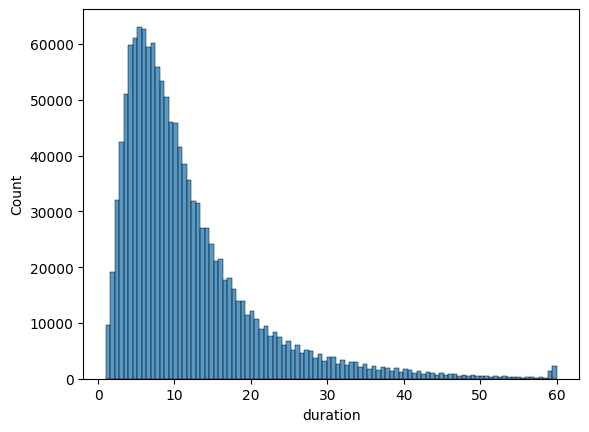

In [18]:
MIN_DURATION = 1
MAX_DURATION = 60


def filter_outliers(df: pd.DataFrame, min_duration: int = 1, max_duration: int = 60) -> pd.DataFrame:
    return df[df["duration"].between(min_duration, max_duration)]


train_df = filter_outliers(train_df)
sns.histplot(train_df["duration"], bins=100)


### 2-2 Prepare features

#### 2-2-1 Categorical features

Most machine learning models don't work with categorical features. Because of this, they must be transformed so that the ML model can consume them.

In [19]:
CATEGORICAL_COLS = ["PULocationID", "DOLocationID"]


def encode_categorical_cols(df: pd.DataFrame, categorical_cols: List[str] = None) -> pd.DataFrame:
    if categorical_cols is None:
        categorical_cols = ["PULocationID", "DOLocationID", "passenger_count"]
    df[categorical_cols] = df[categorical_cols].fillna(-1).astype("int")
    df[categorical_cols] = df[categorical_cols].astype("str")
    return df


train_df = encode_categorical_cols(train_df)


In [20]:
def extract_x_y(
    df: pd.DataFrame,
    categorical_cols: List[str] = None,
    dv: DictVectorizer = None,
    with_target: bool = True,
) -> dict:

    if categorical_cols is None:
        categorical_cols = ["PULocationID", "DOLocationID", "passenger_count"]
    dicts = df[categorical_cols].to_dict(orient="records")

    y = None
    if with_target:
        if dv is None:
            dv = DictVectorizer()
            dv.fit(dicts)
        y = df["duration"].values

    x = dv.transform(dicts)
    return x, y, dv


X_train, y_train, dv = extract_x_y(train_df)
X_train , y_train

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 4029762 stored elements and shape (1343254, 528)>,
 array([ 6.03333333, 27.6       , 15.21666667, ..., 22.        ,
        13.        , 22.88333333], shape=(1343254,)))

## 3 - Train model

We train a basic linear regression model to have a baseline performance

In [21]:
def train_model(x_train: csr_matrix, y_train: np.ndarray):
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    return lr


model = train_model(X_train, y_train)


## 4 - Evaluate model

We evaluate the model on train and test data

### 4-1 On train data

In [22]:
def predict_duration(input_data: csr_matrix, model: LinearRegression):
    return model.predict(input_data)


def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray):
    return root_mean_squared_error(y_true, y_pred)


prediction = predict_duration(X_train, model)
train_me = evaluate_model(y_train, prediction)
train_me

6.782411870275719

### 4-2 On test data

In [23]:
test_df = load_data(test_path)

In [24]:
test_df = compute_target(test_df)
test_df = encode_categorical_cols(test_df)
X_test, y_test, _ = extract_x_y(test_df, dv=dv)

In [25]:
y_pred_test = predict_duration(X_test, model)
test_me = evaluate_model(y_test, y_pred_test)
test_me

58.375056807169976

## 5 - Log Model Parameters to MlFlow

Now that all our development functions are built and tested, let's create a training pipeline and log the training parameters, logs and model to MlFlow.

Create a training flow, log all the important parameters, metrics and model. Try to find what could be important and needs to be logged.

In [26]:
N_ESTIMATORS = 50

In [27]:
import loguru
from sklearn.ensemble import RandomForestRegressor

# Set the experiment name
# mlflow.set_experiment("taxi-trip-duration")

# Load data
train_df = load_data(train_path)
test_df = load_data(test_path)
loguru.logger.info("✅ Data loaded ")
# Filter outliers and compute target
train_df = compute_target(train_df)
train_df = filter_outliers(train_df)

test_df = compute_target(test_df)
test_df = filter_outliers(test_df)
loguru.logger.info("✅ Train data processed")


# Encode categorical columns
train_df = encode_categorical_cols(train_df)
X_test, y_test, _ = extract_x_y(test_df, dv=dv)

# Extract X and y
test_df = encode_categorical_cols(test_df)
X_train, y_train, _ = extract_x_y(train_df, dv=dv)
loguru.logger.info("✅ Created X,y")

# Train model
loguru.logger.info("Training Random Forest model with {} estimators", N_ESTIMATORS)
forest = RandomForestRegressor(n_estimators=N_ESTIMATORS
                               , random_state=42
                               ,verbose=2
                               ,max_depth=10)
forest.fit(X_train, y_train)
loguru.logger.info("✅ Model trained")
# Evaluate model on train set
forest_train_pred = forest.predict(X_train)
train_rmse = evaluate_model(y_train, forest_train_pred)
loguru.logger.info("Train RMSE: {:.2f}", train_rmse)

# Evaluate model on test set
forest_test_pred = forest.predict(X_test)
test_rmse = evaluate_model(y_test, forest_test_pred)
loguru.logger.info("Test RMSE: {:.2f}", test_rmse)

2025-03-14 10:48:25.422 | INFO     | __main__:<module>:10 - ✅ Data loaded 
2025-03-14 10:48:25.781 | INFO     | __main__:<module>:17 - ✅ Train data processed
2025-03-14 10:48:46.735 | INFO     | __main__:<module>:27 - ✅ Created X,y
2025-03-14 10:48:46.737 | INFO     | __main__:<module>:30 - Training Random Forest model with 50 estimators


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.2min


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


2025-03-14 10:50:19.970 | INFO     | __main__:<module>:36 - ✅ Model trained
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.6s
2025-03-14 10:50:21.941 | INFO     | __main__:<module>:40 - Train RMSE: 7.34
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s
2025-03-14 10:50:23.667 | INFO     | __main__:<module>:45 - Test RMSE: 9.54


In [28]:
forest.predict(X_test[:5])

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


array([10.10391846, 10.10391846, 10.10391846, 10.10391846, 10.10391846])

In [29]:
from mlflow.models.signature import infer_signature

# Start a run
with mlflow.start_run() as run:
    run_id = run.info.run_id

    # Set tags for the run
    mlflow.set_tag("model", "Random Forest")
    mlflow.set_tag("model_version", "v1")
    
    # Log parameters 
    mlflow.log_params({"n_estimators": 100, "random_state": 42})
    # Log metrics
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)

    # Log your model
    signature = infer_signature(X_train, forest.predict(X_train))
    mlflow.sklearn.log_model(forest,'random_forest',  signature=signature)
    loguru.logger.info("✅ Model logged as 'random_forest'")    

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.6s
2025-03-14 10:50:30.107 | INFO     | __main__:<module>:20 - ✅ Model logged as 'random_forest'


🏃 View run flawless-bear-163 at: http://localhost:5000/#/experiments/592261138735497612/runs/58ac76007cf64e74acaf245de989888b
🧪 View experiment at: http://localhost:5000/#/experiments/592261138735497612


If the model is satisfactory, we stage it as production using the appropriate version. This will help us retreiving it for predictions.

Create a mlflow client and use the [mlflow documentation](https://mlflow.org/docs/latest/python_api/mlflow.client.html?highlight=transition_model_version_stage#mlflow.client.MlflowClient.transition_model_version_stage) to stage the appropriate model as being in "production".

In [30]:
client = MlflowClient()
...

## Saving the model in local 

In [31]:
import os 
import pickle
if not os.path.exists("../models"):
    os.makedirs("../models")
    print(f"New directory 'models' created!")
with open("../models/forest_model.pkl", "wb") as f:
    pickle.dump(forest, f)

New directory 'models' created!


## Productionizing the model

Now that we have a working logic, create a python package to make it easier to use.  
The package could have the following structure (not everything is mandatory):
```
yellowcab/
    __init__.py
    data.py
    model.py
    predict.py
    train.py
    utils.py
```
